# Reconstruction Search Evaluation
Parse, evaluate and visualize the reconstruction search results

In [1]:
import os
import sys
from pathlib import Path
import json
import copy
import math
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pandas as pd
import seaborn as sns


# Default plot size
plt.rcParams["figure.figsize"] = [30,15]
# sns.set()

In [24]:
def add_thumbnail(ax, file, x, y):
    image = plt.imread(str(file))
    # Check if the RED (0 index) channel is white (1.0)
    bg_mask = image[:,:,0] == 1.0
    # Then set the ALPHA channel to 0
    image[bg_mask, 3] = 0
    offset_image = OffsetImage(image, zoom=0.4)
    ab = AnnotationBbox(offset_image, (x, y), frameon=False)
    ax.add_artist(ab)

def plot_rollout(log_file):
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    current_iou = 0
    prev_iou = 0
    valid_step = []
    valid_iou = []
    invalid_step = []
    invalid_iou = []
    all_step = []
    max_iou = []
    rollout_lines = []
    prev_rollout_attempt = 0
    thumbnails = []
    for action in log_data:
        rollout_attempt = action["rollout_attempt"]
        if rollout_attempt != prev_rollout_attempt:
            current_iou = 0
        step = action["used_budget"]
        iou = action["current_iou"]
        all_step.append(step)
        max_iou.append(action["max_iou"])
        if iou is None:
            invalid_step.append(step)
            invalid_iou.append(current_iou)
        else:
            valid_step.append(step)
            valid_iou.append(iou)
            current_iou = iou
        if rollout_attempt != prev_rollout_attempt:
            prev_rollout_attempt = rollout_attempt
            rollout_lines.append(step)
        iou_delta = math.fabs(prev_iou - current_iou)
        if "screenshot" in action and iou is not None and iou_delta > 0.15:
            thumbnails.append({
                "x": step - 0.5,
                "y": current_iou,
                "file": log_file.parent / action["screenshot"]
            })
        prev_iou = current_iou
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylim([-0.05, 1.05])
    # Rollout lines
    for line in rollout_lines:
        plt.axvline(x=line, color='silver')
    for thumbnail in thumbnails:
        add_thumbnail(ax, thumbnail["file"], thumbnail["x"], thumbnail["y"])
    ax.scatter(invalid_step, invalid_iou, 75, color='r')
    ax.scatter(valid_step, valid_iou, 75, color='b')
    ax.plot(all_step, max_iou)
    ax.set_xlabel('Step')
    ax.set_ylabel('IoU')
    ax.set_title(f"{log_file.stem}")
    plt.show()


def plot_perfect_reconstructions(full_recon_xs, full_recon_ys, labels, title, regraph_limit=None, color=None):
    fig, ax = plt.subplots()
    # Manually set this to the height of the test set
#     ax.set_ylim([0.4, 0.9])
    for index, x in enumerate(full_recon_xs):
        linestyle = "-"
        if labels is not None:
            if labels[index] == "Ground Truth":
                linestyle = "--"
            ax.plot(x, full_recon_ys[index], label=labels[index], color=color[index], linewidth=4, linestyle=linestyle)
        else:
            ax.plot(x, full_recon_ys[index], linewidth=4, color=color[index])
    if regraph_limit is not None:
        ax.axhline(y=regraph_limit, color='dimgray', linestyle='--')
        ax.text(90, regraph_limit - 0.025,'Estimated Representation Upper Limit')

    ax.set_xlabel('Steps')
    ax.set_ylabel('Exact Reconstruction %')
    if title is not None:
        ax.set_title(title)
    if labels is not None:
        ax.legend(loc="upper right", prop={"size":20})
    plt.show()
    
    
def plot_iou_over_time(iou_over_time, labels=None, title=None, color=None):
    fig, ax = plt.subplots()
#     ax.set_ylim([0.6, 0.9])
    ax.set_ylim([-0.05, 1.05])
    for index, iot in enumerate(iou_over_time):
        if labels is not None:
            ax.plot(range(1, len(iot) + 1), iot, label=labels[index], color=color[index], linewidth=4)
        else:
            ax.plot(range(1, len(iot) + 1), iot, linewidth=4, color=color[index])
    ax.set_xlabel('Step')
    ax.set_ylabel('IoU')
    if title is not None:
        ax.set_title(title)
    if labels is not None:
        ax.legend(loc="lower right", prop={"size":20})
    plt.show()

def plot_bargraph(labels, values, title=None, color=None, ylim=None):
    fig, ax = plt.subplots()
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.bar(labels, values, color=color)
    if title is not None:
        ax.set_title(title)
    plt.show()
    
def plot_average_probabilities(log_file):
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    probabilities = []
    for action in log_data:
        probabilities.append(action["probabilities"])
    probs_mean = np.mean(probabilities, axis=0)
    fig, ax = plt.subplots()
#     for prob in probabilities:
#         ax.plot(range(0, len(prob)), prob, linewidth=1)
    ax.plot(range(0, len(probs_mean)), probs_mean, linewidth=4)
    ax.set_title(f"{log_file.stem} Action Probability Curve")
    plt.show()
    
def evaluate_log_file(log_file, budget):
    """Evaluate a single log file"""
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    max_ious = []
    perfect_reconstruction = 0
    best_rollout_attempt = -1
    best_rollout_attempt_index = -1
    current_iou = 0
    used_budget = 0
    
    for index, action in enumerate(log_data):
        # Limit to the budget length
        if action["used_budget"] < budget:
            used_budget = action["used_budget"]
            if action["max_iou"] > current_iou:
                current_iou = action["max_iou"]
                best_rollout_attempt = action["rollout_attempt"]
                best_rollout_attempt_index = index
            max_ious.append(action["max_iou"])
            if perfect_reconstruction == 0:
                if math.isclose(action["max_iou"], 1, abs_tol=0.00001):
                    perfect_reconstruction = action["used_budget"] + 1

    
    best_rollout_length = 0
    # If this was a beam search we will have a prefix that we can count
    if best_rollout_attempt_index > 0 and "prefix" in log_data[best_rollout_attempt_index]:
        best_rollout_length = len(log_data[best_rollout_attempt_index]["prefix"])

    else:
        max_set = False
        count = False
        max_seen = 0
        best_rollout_length = 1
        # Otherwise loop over again to count the rollout steps taken in the best rollout
        for action in reversed(log_data):
            if action["rollout_attempt"] == best_rollout_attempt:
                if not max_set:
                    # Set the max for this roll out attempt
                    max_seen = action["max_iou"]
                    max_set = True
                # When the max drops below max ever seen, start counting
                if action["max_iou"] < max_seen:
                    count = True
                if count:
                    best_rollout_length += 1
   
    time_taken = log_data[-1]["time"] - log_data[0]["time"]        
    return np.array(max_ious), time_taken, perfect_reconstruction, best_rollout_length, used_budget


def get_design_extrude_count(file):
    """Get the number of extrude steps in a design"""
    with open(file, encoding="utf8") as f:
        json_data = json.load(f)
    timeline = json_data["timeline"]
    entities = json_data["entities"]
    extrude_count = 0
    for timeline_object in timeline:
        entity_uuid = timeline_object["entity"]
        entity_index = timeline_object["index"]
        entity = entities[entity_uuid]
        if entity["type"] == "ExtrudeFeature":
            extrude_count += 1
    return extrude_count


def get_design_extrude_counts(dataset_dir, split_file):
    assert split_file.exists()
    with open(split_file, "r", encoding="utf8") as f:
        split_data = json.load(f)
    counts = []
    for index, test_file in enumerate(split_data["test"]):
        dataset_json_file = dataset_dir / f"{test_file}.json"
        extrude_count = get_design_extrude_count(dataset_json_file)
        counts.append(extrude_count)
    return counts

def get_regraph_limit(results_file, split_file):
    assert results_file.exists()
    with open(results_file, "r", encoding="utf8") as f:
        results_data = json.load(f)
    assert split_file.exists()
    with open(split_file, "r", encoding="utf8") as f:
        split_data = json.load(f)
    result_reasons = []
    for file, results in results_data.items():
        file_stem = Path(file).stem
        if file_stem not in split_data["test"]:
            continue
        if len(results) == 0:
            result_reasons.append("Crash or timeout")
        else:
            result = results[0]
            if result["status"] == "Success":
                result_reasons.append(result["status"])
            else:
                if "reason" in result:
                    result_reasons.append(result["reason"])
                elif "exception" in result:
                    result_reasons.append(result["exception"])
                else:
                    print("Nothing???")

    common = dict(Counter(result_reasons).most_common())
    limit = common["Success"]
#     print("Test Success Count", limit)
    if "Extrude doesn't have start or end faces" in common:
        limit += common["Extrude doesn't have start or end faces"]
    if "Crash or timeout" in common:
        limit += common["Crash or timeout"]
    return limit

def get_budget(log_file):
    """Get the budget from a log file"""
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    return log_data[0]["budget"]


def set_array_length(array, length):
    if len(array) > length:
        return array[0:length]
    elif len(array) < length:
        last_value = array[-1]
        num_to_add = length - len(array)
        values_to_add = np.full(num_to_add, last_value)
        return np.append(array, values_to_add)
    else:
        return array


def evaluate(log_dir, dataset_dir, split_file):
    """Evaluate an experiments logs"""
    log_files = [f for f in log_dir.glob("**/*_log.json")]
    log_file_map = {}
    for log_file in log_files:
        log_file_map[log_file.stem[:-4]] = log_file
    
    results_file = log_dir / "search_results.json"
    assert results_file.exists()
    with open(results_file, "r", encoding="utf8") as f:
        results_data = json.load(f)
    
    assert split_file.exists()
    with open(split_file, "r", encoding="utf8") as f:
        split_data = json.load(f)
    

    budget = get_budget(log_files[0])
    budgets_used = []
    times_taken = []
    max_iou = []
    max_iou_over_time = np.zeros(shape=(len(split_data["test"]), budget))
    perfect_reconstructions = []
    sequence_deltas = []
    sequence_deltas_perfect = []

    result = {
        "log_count": 0,
        "files_processed": 0,
    }
    for index, test_file in enumerate(split_data["test"]):
        if test_file in results_data:
            result["files_processed"] += 1
            processing_result = results_data[test_file]
            status = f"files_{processing_result['status'].lower()}"
            if status not in result:
                result[status] = 0
            result[status] += 1
        if test_file not in log_file_map and test_file not in results_data:
            print(f"File does not have a log or processing record! {test_file}")
        
        # Set some default values
        max_ious_raw = np.zeros(budget)
        perfect_reconstruction = 0
        best_rollout_length = 100
        used_budget = 0        
        
        if test_file in log_file_map:
            result["log_count"] += 1     
            log_file = log_file_map[test_file]
            max_ious_raw, time_taken, perfect_reconstruction, best_rollout_length, used_budget = evaluate_log_file(log_file, budget)

       
        dataset_json_file = dataset_dir / f"{test_file}.json"
        extrude_count = get_design_extrude_count(dataset_json_file)
        sequence_delta = abs(best_rollout_length - extrude_count)
        sequence_deltas.append(sequence_delta)
        if perfect_reconstruction > 1:
            sequence_deltas_perfect.append(sequence_delta)
        if test_file in log_file_map:
            times_taken.append(time_taken)
        budgets_used.append(used_budget)
        max_ious = set_array_length(max_ious_raw, budget)
        assert len(max_ious) == budget
        max_iou_max = np.max(max_ious)
        perfect_reconstructions.append(perfect_reconstruction)           
        max_iou.append(max_iou_max)
        max_iou_over_time[index] = max_ious
    
    
    assert len(sequence_deltas) == len(split_data["test"])
    result["test_file_count"] = len(split_data["test"])
    result["time_taken_mean"] = np.mean(times_taken)
    result["budget_used_mean"] = np.mean(budgets_used)
    result["sequence_delta_mean"] = np.mean(sequence_deltas)
    result["sequence_delta_perfect_mean"] = np.mean(sequence_deltas_perfect)
    result["perfect_reconstruction"] = np.count_nonzero(perfect_reconstructions)
    result["perfect_reconstructions"] = np.array(perfect_reconstructions)
    result["perfect_reconstruction_percent"] = result["perfect_reconstruction"] / len(split_data["test"])
    result["max_iou_mean"] = np.mean(max_iou)
    result["max_iou_over_time"] = max_iou_over_time
 
    return result

## Evaluate the results from each experiment

In [3]:
dataset_dir = Path("/Users/willisk/Autodesk/FusionGallery/Data/Reconstruction/d7/d7")
split_file = dataset_dir.parent / "train_test.json"

In [4]:
log_dirs = [
    Path("../log/super_rand_05"),
    Path("../log/rand_rand_03"),
    Path("../log/super_beam_04"),
    Path("../log/rand_beam_01")
]
labels = [
    "Supervised Agent, Random Search",
    "Random Agent, Random Search",    
    "Supervised Agent, Beam Search",    
    "Random Agent, Beam Search"
]
colors = sns.color_palette("hls", len(labels))
results = {}
for log_dir, label in zip(log_dirs, labels):
    result = evaluate(log_dir, dataset_dir, split_file)
    results[label] = result

results_df = pd.DataFrame(results)
test_file_count = results_df.loc["test_file_count"][0]
results_df

,"Supervised Agent, Random Search","Random Agent, Random Search","Supervised Agent, Beam Search","Random Agent, Beam Search"
log_count,1700,1707,1708,1708
files_processed,1725,1725,1725,1725
files_success,1691,1693,1706,1706
files_fail,17,17,17,17
files_crash,15,14,NaN,2
files_timeout,2,1,2,NaN
test_file_count,1725,1725,1725,1725
time_taken_mean,9.41243,4.9603,18.4671,18.7641
budget_used_mean,36.3154,51.0278,41.4232,65.269
sequence_delta_mean,2.56812,2.82435,1.90725,2.13739


## Plot the reconstruction performance over time

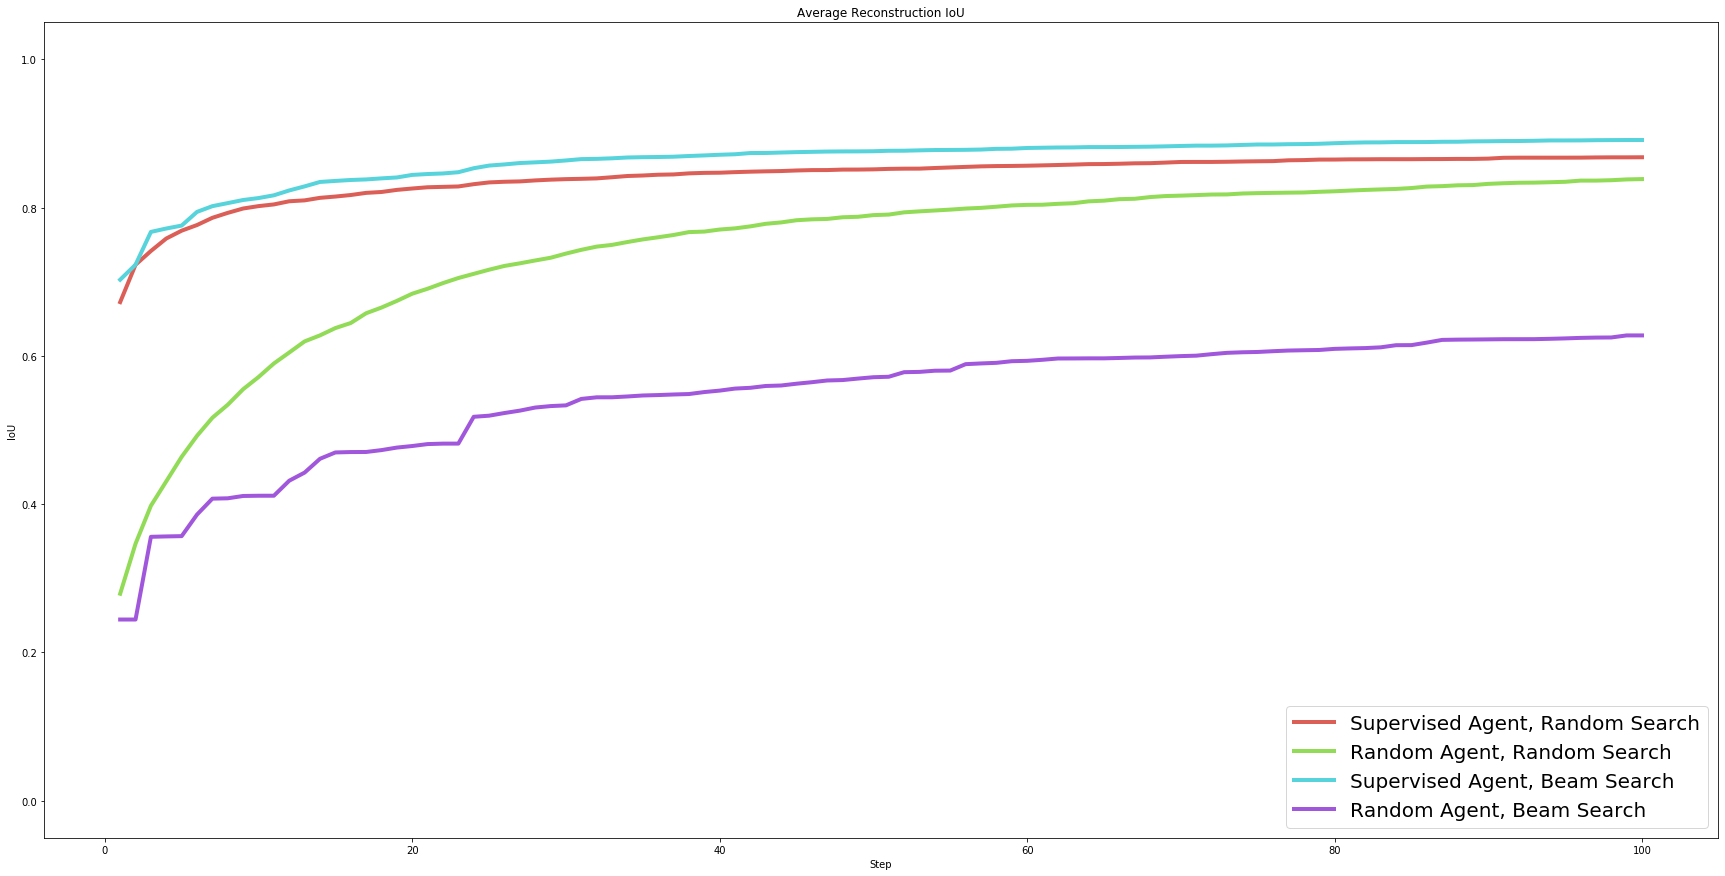

In [5]:
max_iou_mean_over_time = [ np.mean(result, axis=0) for result in results_df.loc["max_iou_over_time"].tolist() ]
plot_iou_over_time(max_iou_mean_over_time, labels, "Average Reconstruction IoU", color=colors)

## Cumulative Exact Reconstructions

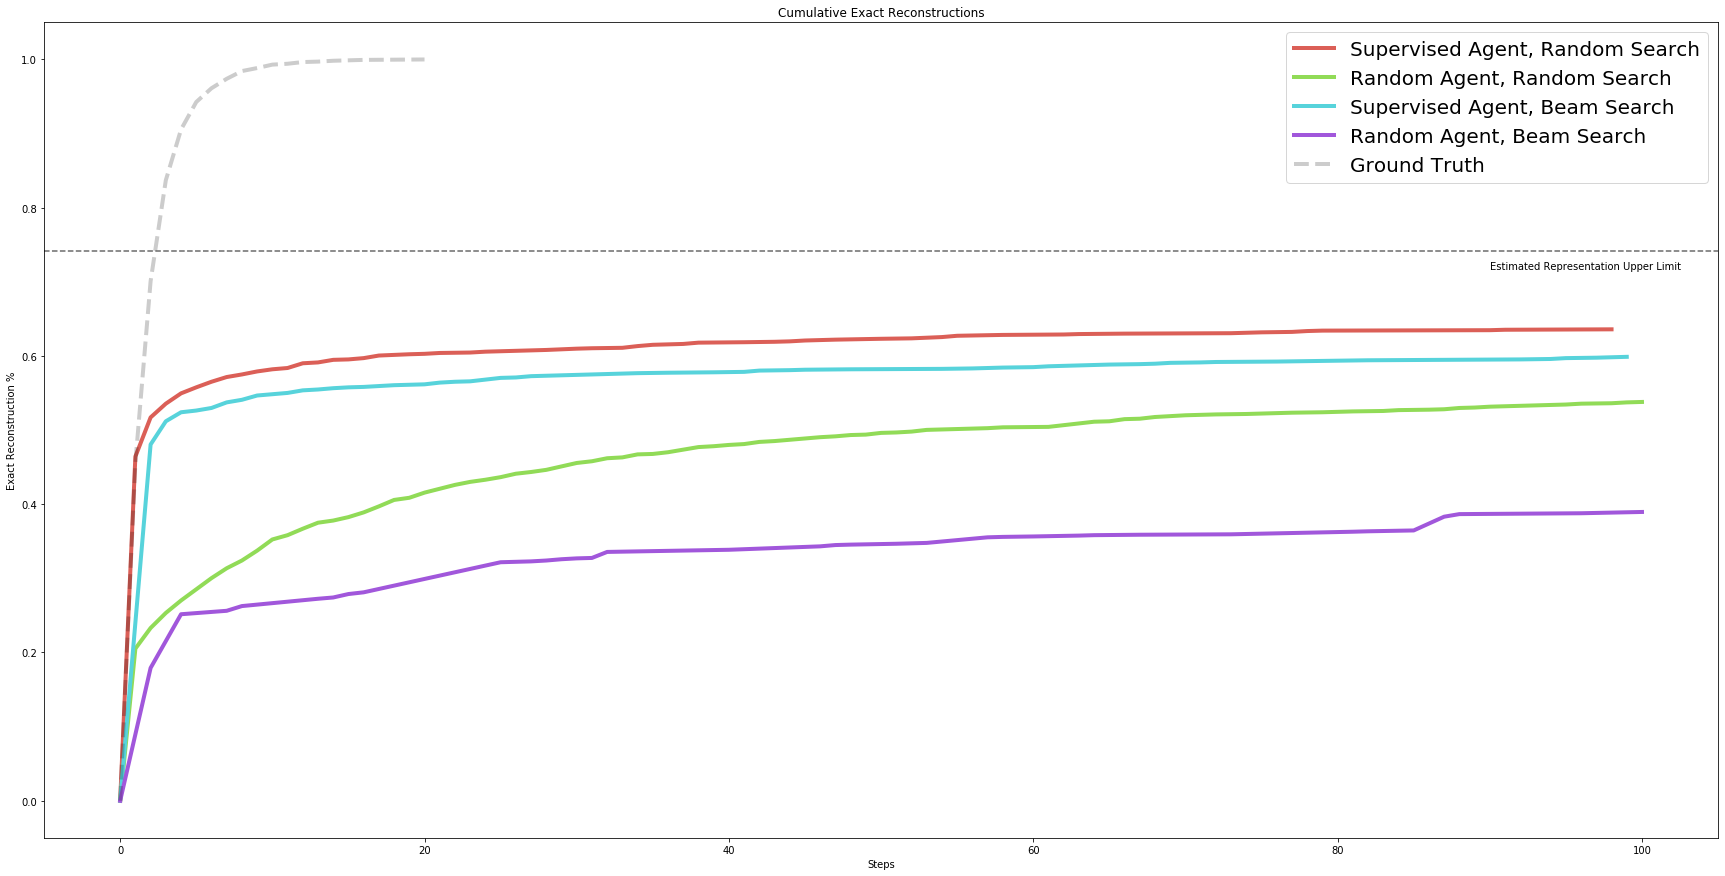

In [25]:
perfect_reconstructions = results_df.loc["perfect_reconstructions"].tolist()

full_recon_ys = [None] * len(perfect_reconstructions)
full_recon_xs = [None] * len(perfect_reconstructions)

for index, perfect_reconstruction in enumerate(perfect_reconstructions):
    (unique, counts) = np.unique(perfect_reconstruction, return_counts=True)
    # Zero out the reconstructions that failed
    counts[0] = 0
    cumsum = np.cumsum(counts) / test_file_count
    full_recon_ys[index] = cumsum
    full_recon_xs[index] = unique

extrude_counts = get_design_extrude_counts(dataset_dir, split_file)
(unique, counts) = np.unique(extrude_counts, return_counts=True)
cumsum = list(np.cumsum(counts) / test_file_count)
unique = list(unique)
cumsum.insert(0, 0)
unique.insert(0, 0)
full_recon_ys.append(cumsum)
full_recon_xs.append(unique)
labels_gt = copy.deepcopy(labels)
labels_gt.append("Ground Truth")
colors_gt = copy.deepcopy(colors)
colors_gt.append([0.0, 0.0, 0.0, 0.2])

regraph_result_file = Path("../log/regraph/regraph_results_RegraphPerFace_05.json")
regraph_limit = get_regraph_limit(regraph_result_file, split_file)
regraph_limit_percent = regraph_limit / test_file_count

plot_perfect_reconstructions(full_recon_xs, full_recon_ys, labels_gt, "Cumulative Exact Reconstructions", regraph_limit=regraph_limit_percent, color=colors_gt)

## IoU Average

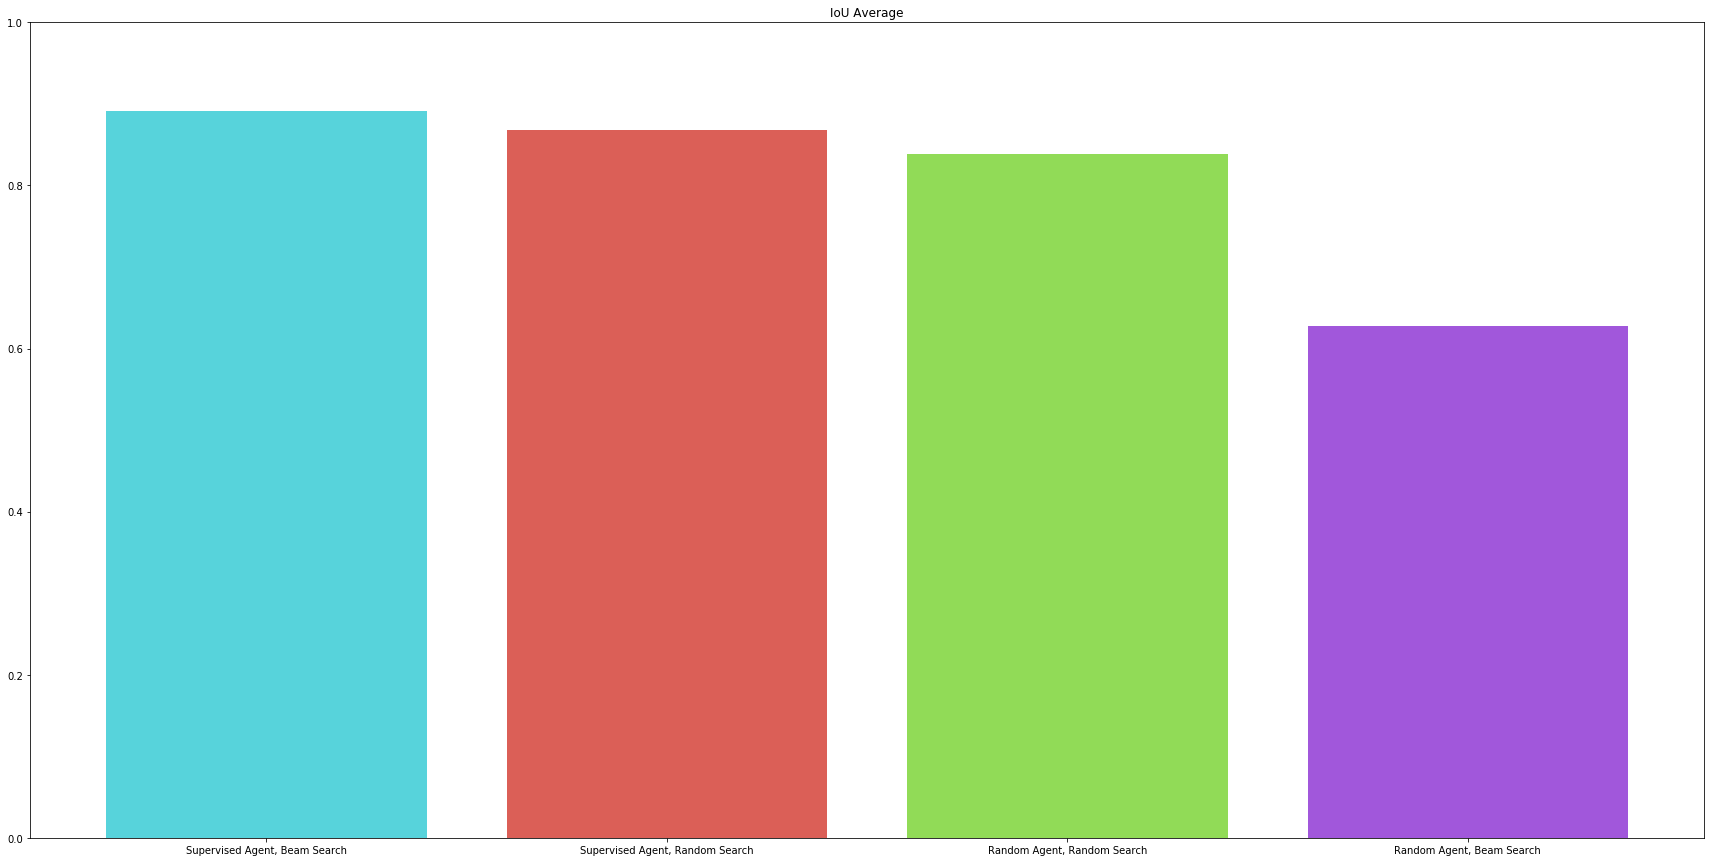

In [9]:
max_iou_mean_100 = []
max_iou_mean_50 = []
for max_iou_result in max_iou_mean_over_time:
    max_iou_mean_100.append(np.max(max_iou_result[:100]))
    max_iou_mean_50.append(np.max(max_iou_result[:50]))

# Plot the results after 100 steps
max_iou_mean = max_iou_mean_100

max_iou_mean_data = zip(max_iou_mean, labels, colors)
max_iou_mean_data_sorted = sorted(max_iou_mean_data, reverse=True)
max_iou_mean_data_unzip = list(zip(*max_iou_mean_data_sorted))

plot_bargraph(max_iou_mean_data_unzip[1], max_iou_mean_data_unzip[0], "IoU Average", color=max_iou_mean_data_unzip[2], ylim=[0,1])

## Sequence Delta Average

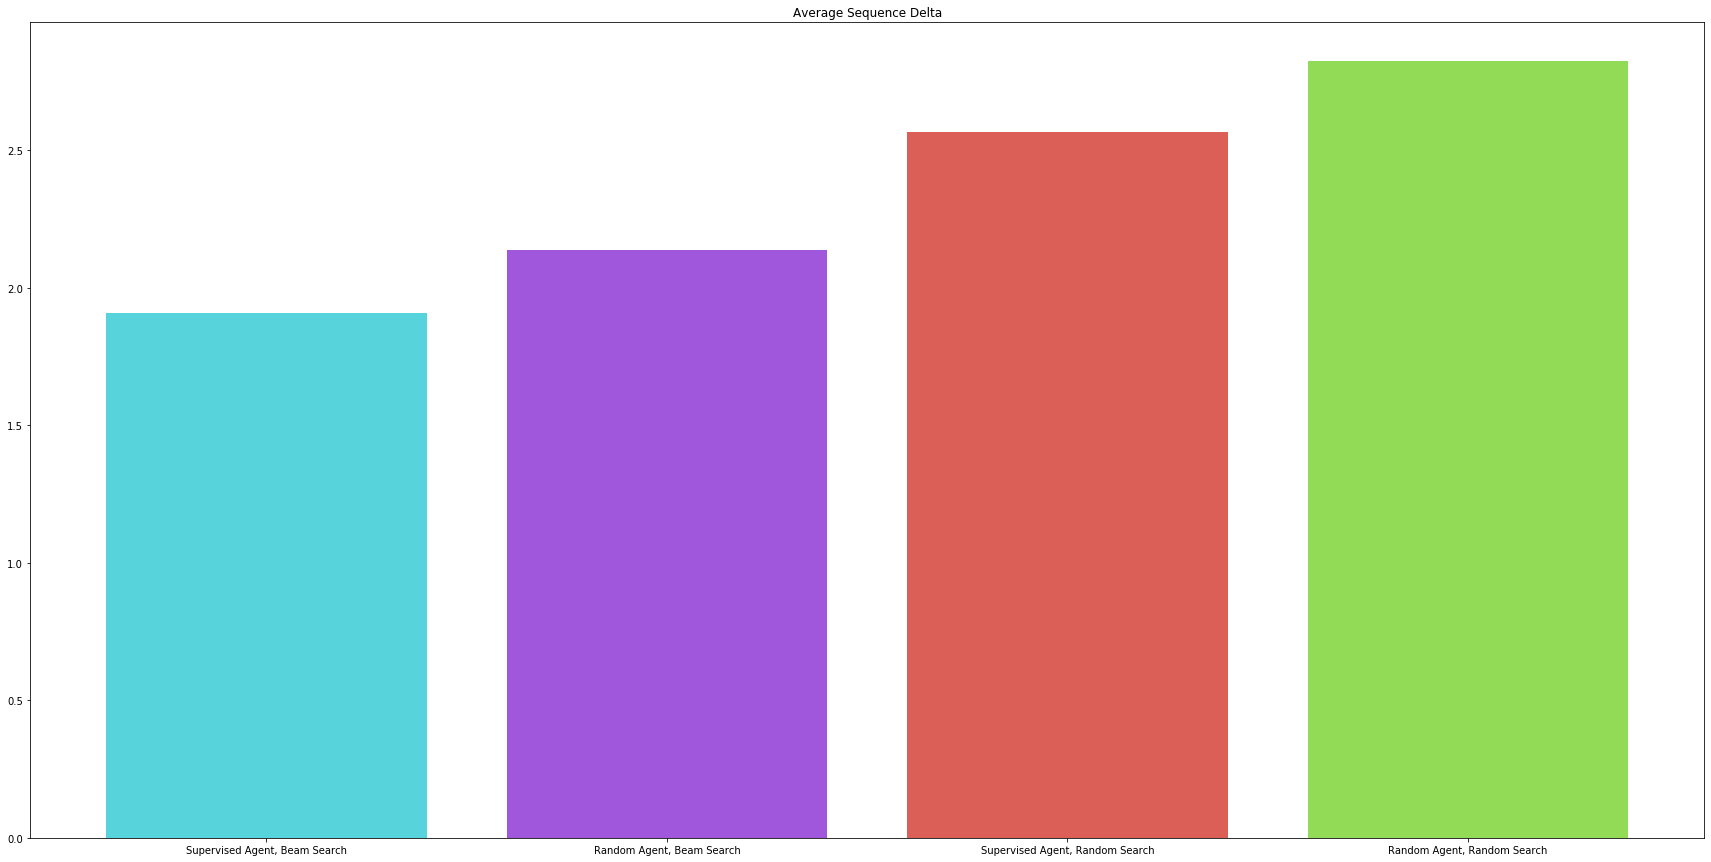

In [10]:
sequence_delta_mean = results_df.loc["sequence_delta_mean"].tolist()

sequence_delta_data = zip(sequence_delta_mean, labels, colors)
sequence_delta_data_sorted = sorted(sequence_delta_data, reverse=False)
sequence_delta_data_unzip = list(zip(*sequence_delta_data_sorted))

plot_bargraph(sequence_delta_data_unzip[1], sequence_delta_data_unzip[0], "Average Sequence Delta", color=sequence_delta_data_unzip[2])

## Test Files Without Logs

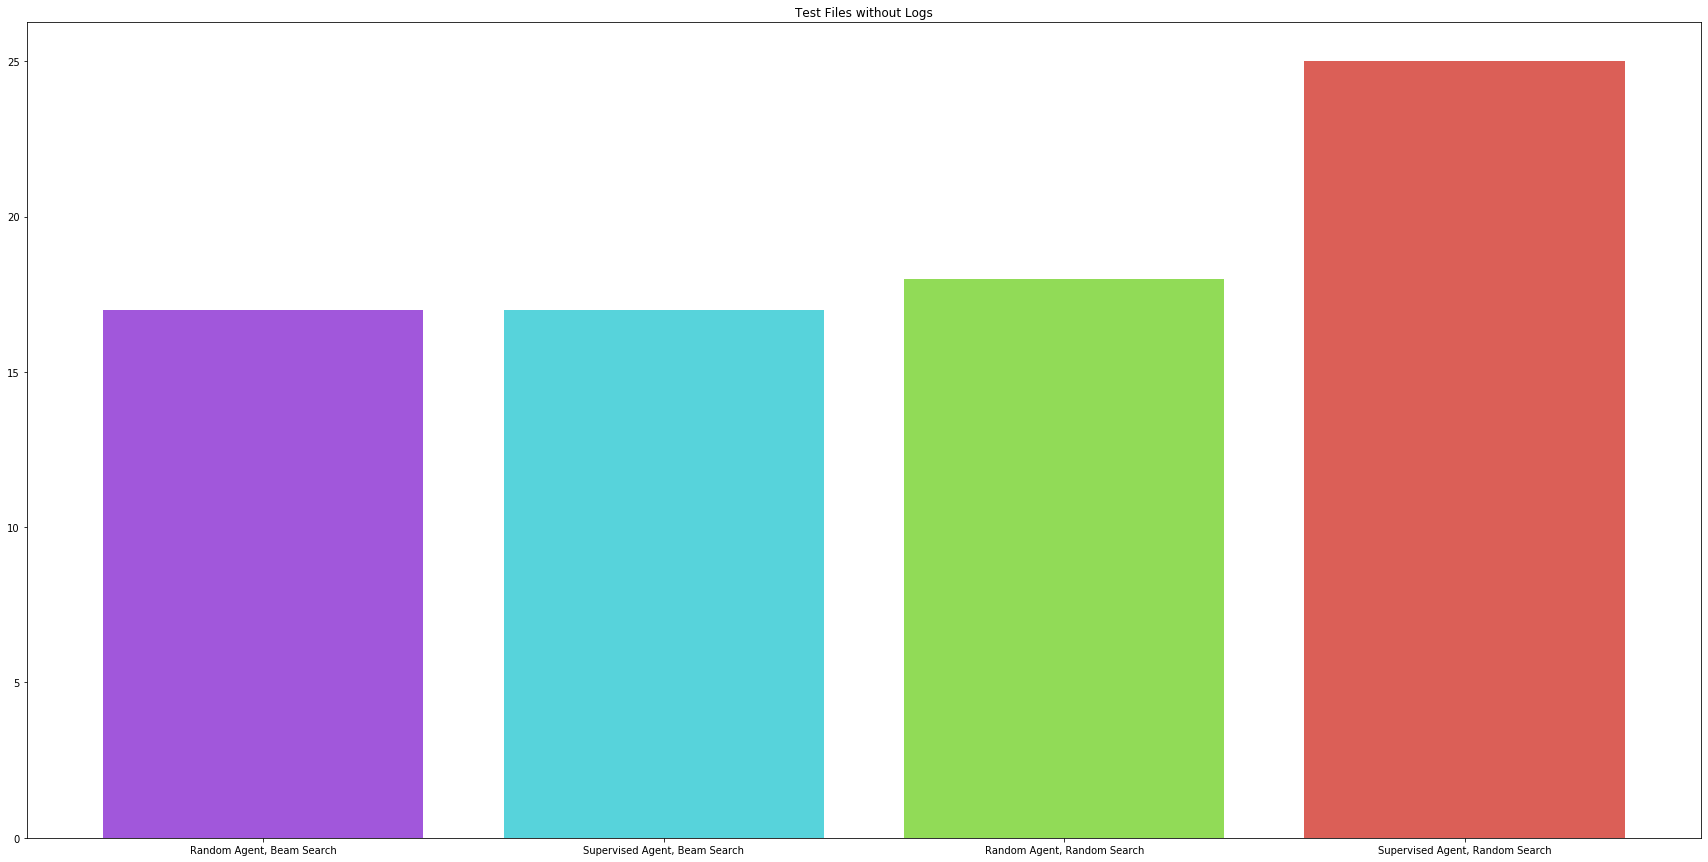

In [11]:
logs_missing = results_df.loc["files_processed"].subtract(results_df.loc["log_count"]).tolist()

logs_missing_data = zip(logs_missing, labels, colors)
logs_missing_data_sorted = sorted(logs_missing_data, reverse=False)
logs_missing_data_unzip = list(zip(*logs_missing_data_sorted))

plot_bargraph(logs_missing_data_unzip[1], logs_missing_data_unzip[0], "Test Files without Logs", color=logs_missing_data_unzip[2])

## Results Table

In [12]:
# Get the number of full reconstructions at 50 and 100 steps
full_recon_50 = []
full_recon_100 = []
for xs, ys in zip(full_recon_xs[:-1], full_recon_ys[:-1]):
    prev_x = 0
    for index, x in enumerate(xs):
        if x == 50:
            result_y = ys[index]
            full_recon_50.append(result_y)
            break
        elif x > 50:
            result_y = ys[prev_index]
            full_recon_50.append(result_y)
            break
        prev_index = index
    full_recon_100.append(ys[-1])        

columns = pd.MultiIndex.from_product([['Avg IoU', 'Exact IoU'], ['50', '100']])
  
table_results = np.transpose([
    max_iou_mean_100,
    max_iou_mean_50,
    full_recon_50,
    full_recon_100
])

df = pd.DataFrame(table_results, index=labels, columns=columns)
df["Avg Seq Diff"] = sequence_delta_mean
df.round(4).to_clipboard()
df.round(4)

Avg IoU         Exact IoU         Avg Seq Diff
                                     50     100        50     100             
Supervised Agent, Random Search  0.8681  0.8518    0.6232  0.6359       2.5681
Random Agent, Random Search      0.8386  0.7900    0.4962  0.5380       2.8243
Supervised Agent, Beam Search    0.8913  0.8762    0.5820  0.5988       1.9072
Random Agent, Beam Search        0.6277  0.5713    0.3455  0.3896       2.1374

In [13]:
def round(x):
    return f"{x:.4f}"

def percent(x):
    return f"{x * 100:.2f}%"

results_table_file = Path("../log/reconstruction_results.tex")
df.to_latex(buf=results_table_file, formatters=[round, round, round, round, round], multicolumn=True, column_format="l|rrrrr", multicolumn_format="c")

## Results Figure

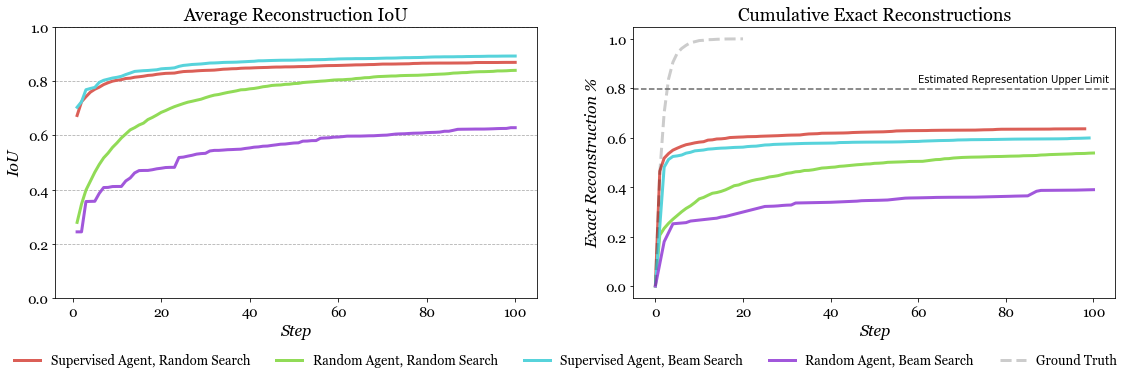

In [14]:
font_family = "Georgia"
title_font = font_manager.FontProperties(family=font_family,
                                   weight='normal',
                                   style='normal', size=18)
legend_font = font_manager.FontProperties(family=font_family,
                                   weight='normal',
                                   style='normal', size=13)
label_font = font_manager.FontProperties(family=font_family,
                                   weight='normal',
                                   style='italic', size=16)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(19, 5)
ax1.set_ylim([0.0, 1.0])
for index, iot in enumerate(max_iou_mean_over_time):
    ax1.plot(range(1, len(iot) + 1), iot, label=labels_gt[index], color=colors[index], linewidth=3)
ax1.set_xlabel('Step', fontproperties=label_font)
ax1.set_ylabel('IoU', fontproperties=label_font)
ax1.set_title('Average Reconstruction IoU', fontproperties=title_font)
for tick in ax1.get_xticklabels():
    tick.set_fontname(font_family)
for tick in ax1.get_yticklabels():
    tick.set_fontname(font_family)
ax1.tick_params(axis='both', labelsize=14)
ax1.yaxis.grid(linestyle='--')
    
# ax2.set_ylim([0, 1800])
for index, x in enumerate(full_recon_xs):
    linestyle = "-"
    if labels_gt[index] == "Ground Truth":
        linestyle = "--"
    ax2.plot(x, full_recon_ys[index], label=labels_gt[index], color=colors_gt[index], linewidth=3, linestyle=linestyle)
ax2.set_xlabel('Step', fontproperties=label_font)
ax2.set_ylabel('Exact Reconstruction %', fontproperties=label_font)
# lgd = ax2.legend(loc="upper left", prop=legend_font, bbox_to_anchor=(1.02,1.05), frameon=False)
lgd = plt.legend(loc="lower right", prop=legend_font, frameon=False, bbox_transform=fig.transFigure, bbox_to_anchor=(0.91,-0.1), ncol=len(labels_gt))
ax2.set_title("Cumulative Exact Reconstructions", fontproperties=title_font)
for tick in ax2.get_xticklabels():
    tick.set_fontname(font_family)
for tick in ax2.get_yticklabels():
    tick.set_fontname(font_family)
ax2.tick_params(axis='both', labelsize=14)
# ax2.yaxis.grid(linestyle='--')
ax2.axhline(y=regraph_limit_percent, color='dimgray', linestyle='--')
ax2.text(60, regraph_limit_percent + 0.025,'Estimated Representation Upper Limit')

results_plot_file = Path("../log/reconstruction_results.pdf")
# Save and include the legend
plt.savefig(results_plot_file, bbox_extra_artists=(lgd,), bbox_inches='tight')  
plt.show()


## Create a rollout plot from a single log

In [15]:
# log_file = Path("../log/Couch/Couch_log.json")
# plot_rollout(log_file)

## Action Probability Curve

In [16]:
# plot_average_probabilities(log_file)